In [1]:
import numpy as np
import pandas as pd
import torch
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from mnist import MNIST

import matplotlib.pyplot as plt

data: http://yann.lecun.com/exdb/mnist/

guide: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [2]:
def read_in_data(path, train=True):
    mndata = MNIST(path)
    
    if train:
        images, labels = mndata.load_training()
    else:
        images, labels = mndata.load_testing()
    
    # this is needed if treating as images
    #for i, image in enumerate(images):
    #    images[i] = np.array(image).reshape(28,28)
        
    return images, list(labels)
    
train_images, train_labels = read_in_data('train_data/')
test_images,  test_labels  = read_in_data('test_data/', train=False)

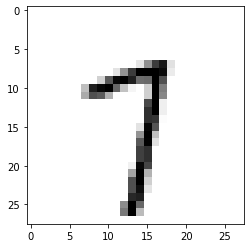

label:  7


In [3]:
def show_image_from_list(image):
    img = image.copy()
    img = np.array(img).reshape(28,28)
    plt.imshow(img, cmap='gray_r')
    plt.show()
    
idx = 42
show_image_from_list(train_images[idx])
print('label: ', train_labels[idx])

# Dataset class

In [4]:
class ImagesDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.image_list = image_list
        self.label_list = label_list
        
    def __len__(self):
        return len(self.label_list)
    
    def __getitem__(self, idx):
        img = self.image_list[idx]
        img = torch.tensor(img).float()
        
        label = self.label_list[idx]
        label = torch.tensor(label).long()
        
        return img, label

In [5]:
train_ds = ImagesDataset(train_images, train_labels)
test_ds  = ImagesDataset(test_images,  test_labels)

train_dl = DataLoader(train_ds, batch_size=100, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=100)

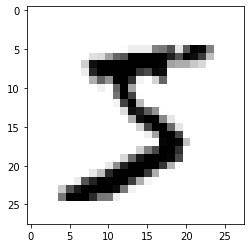

tensor(5)

In [6]:
im, lb = next(iter(train_ds))
show_image_from_list(list(im))
lb

# Models

In [7]:
class FeedForward2Layer(nn.Module):
    def __init__(self, input_size=784, hidden_size=64, output_size=10):
        super(FeedForward2Layer, self).__init__()
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.i2h(x)
        x = self.relu(x)
        x = self.h2o(x)
        
        return x

# Training

In [11]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in dataloader:
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [12]:
# prep
epochs = 30
lossFun = nn.CrossEntropyLoss()
model = FeedForward2Layer()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
test_losses  = []

In [13]:
# train
for epoch in tqdm(range(epochs)):
    print('epoch:', epoch)
    
    train_loss = one_pass(model, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print("Train loss:", train_loss)
    
    test_loss = one_pass(model, test_dl, optimizer, lossFun, backwards=False)
    test_losses.append(test_loss)
    print("Test loss:", test_loss)
    
    train_acc = one_pass_acc(model, train_dl, len(train_ds))
    test_acc  = one_pass_acc(model, test_dl,  len(test_ds))
    print("Train Acc:", train_acc)
    print("Test Acc:", test_acc)

epoch: 0
Train loss: 0.6550902405505379
Test loss: 0.2579012550972402
Train Acc: 0.93525
Test Acc: 0.9302
epoch: 1
Train loss: 0.20612187579274177
Test loss: 0.1968631815398112
Train Acc: 0.95155
Test Acc: 0.9453
epoch: 2
Train loss: 0.1627718978235498
Test loss: 0.1736729652993381
Train Acc: 0.9622833333333334
Test Acc: 0.9529
epoch: 3
Train loss: 0.14720445197386045
Test loss: 0.1695932032552082
Train Acc: 0.9628166666666667
Test Acc: 0.9526
epoch: 4
Train loss: 0.13733801138742516
Test loss: 0.16075460948515682
Train Acc: 0.96625
Test Acc: 0.9579
epoch: 5
Train loss: 0.1346184849133715
Test loss: 0.18218108241504524
Train Acc: 0.9632666666666667
Test Acc: 0.9533
epoch: 6
Train loss: 0.12561358670238407
Test loss: 0.1664320213123574
Train Acc: 0.9699666666666666
Test Acc: 0.96
epoch: 7
Train loss: 0.12615444379781063
Test loss: 0.16107593225548045
Train Acc: 0.96905
Test Acc: 0.9578
epoch: 8
Train loss: 0.1197107718884945
Test loss: 0.17918507658294403
Train Acc: 0.9718666666666667
T

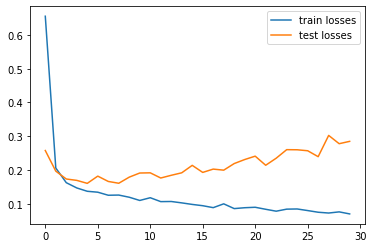

In [20]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train losses', 'test losses'])
plt.show()   # clear overfitting as time goes on

# Save model

In [21]:
torch.save(model.state_dict(), 'feed_forward_model.pth')

# load model

In [33]:
def load_ff_model():
    model = FeedForward2Layer()
    model.load_state_dict(torch.load('feed_forward_model.pth'))
    
    return model
    
model = load_ff_model()

# check loaded model is working

In [34]:
train_acc = one_pass_acc(model, train_dl, len(train_ds))
test_acc  = one_pass_acc(model, test_dl,  len(test_ds))
print("Train Acc:", train_acc)
print("Test Acc:", test_acc)

Train Acc: 0.9792
Test Acc: 0.9599


tensor(7)


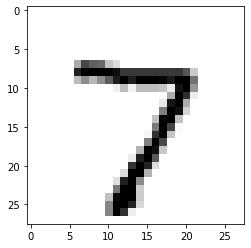

tensor(7)


In [35]:
im, lb = next(iter(test_ds))
print(lb)
show_image_from_list(list(im))
print(torch.argmax(model(im)))

In [38]:
def get_single_prediction(model, image):
    """
    Note that image is expected in the list format to cohere with the mnist load functions
    i.e. 1d list of length 28*28 = 784 instead of a 28 by 28 array
    """
    model.eval()
    yhat = model(image)
    return(torch.argmax(yhat).item())

im, lb = next(iter(test_ds))
get_single_prediction(model, im)

7

# TODO: pygame baby